In [1]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import itertools
from scipy import stats
from scipy.stats import sem  
import nibabel as nib
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.colors as mplcol
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from nilearn import plotting as ni_plt
import matplotlib.colors as colors
import seaborn as sns

In [2]:
fig_dir = '../../paper/figs/source/supplemental_4'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [3]:

def compile_corrs(array_full, iteration):
    """
        Compiles correlation values - as well as other subject specific paramters - creates the compiled pandas dataframe used for figures

        Parameters
        ----------

        file_path : string
            path to npz file containing correlation values

        Returns
        ----------
        results : dataframe
            compiled dataframe with: Subject, electrode, correlation, samples, and sample rate

        """

    return pd.DataFrame({'Correlation': array_full[iteration], 'Iteration': iteration, '# Subjects': np.arange(array_full.shape[1])+1})



In [4]:
ram_data_dir = '../../data/ram'
pyfr_data_dir = '../../data/pyfr'

## Import time stability csv for both datasets

In [5]:
RAM_t_df = pd.read_csv(os.path.join(ram_data_dir, 'ram_time_stability.csv'), index_col=0)
pyFR_t_df = pd.read_csv(os.path.join(pyfr_data_dir, 'pyfr_time_stability.csv'), index_col=0)

In [6]:
chunk_size=1000

## Calculate percent and seconds, compile to long format 

In [7]:
RAM_t_df['time_idx'] = RAM_t_df.index
RAM_t_df['sample_idx'] = (RAM_t_df.index * 1000)+ 1000
RAM_t_df['percent_idx'] = np.round((RAM_t_df.sample_idx / (RAM_t_df.samples/2)), decimals=2)
RAM_t_df['second_idx'] = RAM_t_df['sample_idx']/RAM_t_df.sample_rate

In [8]:
RAM_t_df_long = RAM_t_df.melt(id_vars=['Subject', 'sample_rate', 'samples','time_idx', 'sample_idx', 'percent_idx', 'second_idx'], 
                              var_name='Type', value_name='Correlation')

In [9]:
RAM_t_df_long.head()

,Subject,sample_rate,samples,time_idx,sample_idx,percent_idx,second_idx,Type,Correlation
0,R1061T_RAM_CatFR1_0,250,773040,0,1000,0.00,4.0,rand,0.989058
1,R1061T_RAM_CatFR1_0,250,773040,1,2000,0.01,8.0,rand,0.995228
2,R1061T_RAM_CatFR1_0,250,773040,2,3000,0.01,12.0,rand,0.996639
3,R1061T_RAM_CatFR1_0,250,773040,3,4000,0.01,16.0,rand,0.997428
4,R1061T_RAM_CatFR1_0,250,773040,4,5000,0.01,20.0,rand,0.997841


In [10]:
pyFR_t_df['time_idx'] = pyFR_t_df.index
pyFR_t_df['sample_idx'] = (pyFR_t_df.index * 1000) + 1000
pyFR_t_df['percent_idx'] = np.round((pyFR_t_df.sample_idx / (pyFR_t_df.samples/2)), decimals=2)
pyFR_t_df['second_idx'] = pyFR_t_df['sample_idx']/pyFR_t_df.sample_rate

In [11]:
pyFR_t_df_long = pyFR_t_df.melt(id_vars=['Subject', 'sample_rate', 'samples','time_idx', 'sample_idx', 'percent_idx', 'second_idx'], 
                              var_name='Type', value_name='Correlation')

In [12]:
pyFR_t_df_long.head()

,Subject,sample_rate,samples,time_idx,sample_idx,percent_idx,second_idx,Type,Correlation
0,FR120,250,1950000,0,1000,0.00,4.0,rand,0.985924
1,FR120,250,1950000,1,2000,0.00,8.0,rand,0.993610
2,FR120,250,1950000,2,3000,0.00,12.0,rand,0.995954
3,FR120,250,1950000,3,4000,0.00,16.0,rand,0.996652
4,FR120,250,1950000,4,5000,0.01,20.0,rand,0.997841


## Fine mean sampels

In [13]:
RAM_group = RAM_t_df_long.groupby("Subject").mean() 
RAM_group['samples'].mean()
RAM_half = RAM_t_df_long.loc[(RAM_t_df_long['sample_idx'] <= RAM_group['samples'].mean()/2)]

In [14]:
pyFR_group = pyFR_t_df_long.groupby("Subject").mean() 
pyFR_group['samples'].mean()
pyFR_half = pyFR_t_df_long.loc[(pyFR_t_df_long['sample_idx'] <= pyFR_group['samples'].mean()/2)]

In [15]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i) 
    return(colors_rgba[:N, :3])

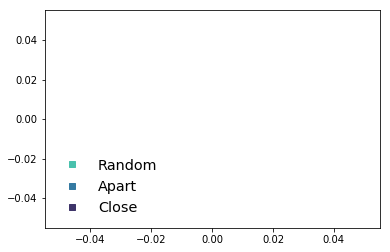

In [16]:
colors = sns.color_palette("mako_r", 3)
# offset = 28 # defines colormap offset from center
# cmaplist = [cmap(i) for i in range(128-offset)] + [cmap(i) for i in range(128+offset,256)]
# spec_spliced = mplcol.LinearSegmentedColormap.from_list('spec_spliced', cmaplist, 256)

cond_names = ['Random', 'Apart', 'Close']
# colors = cmap_discretize(cmap, len(cond_names))
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(3)]
labels = cond_names
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False, fontsize = 'x-large')

def export_legend(legend, filename=os.path.join(fig_dir,'stability_legend.pdf'), expand=[-1,-1,1,1]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

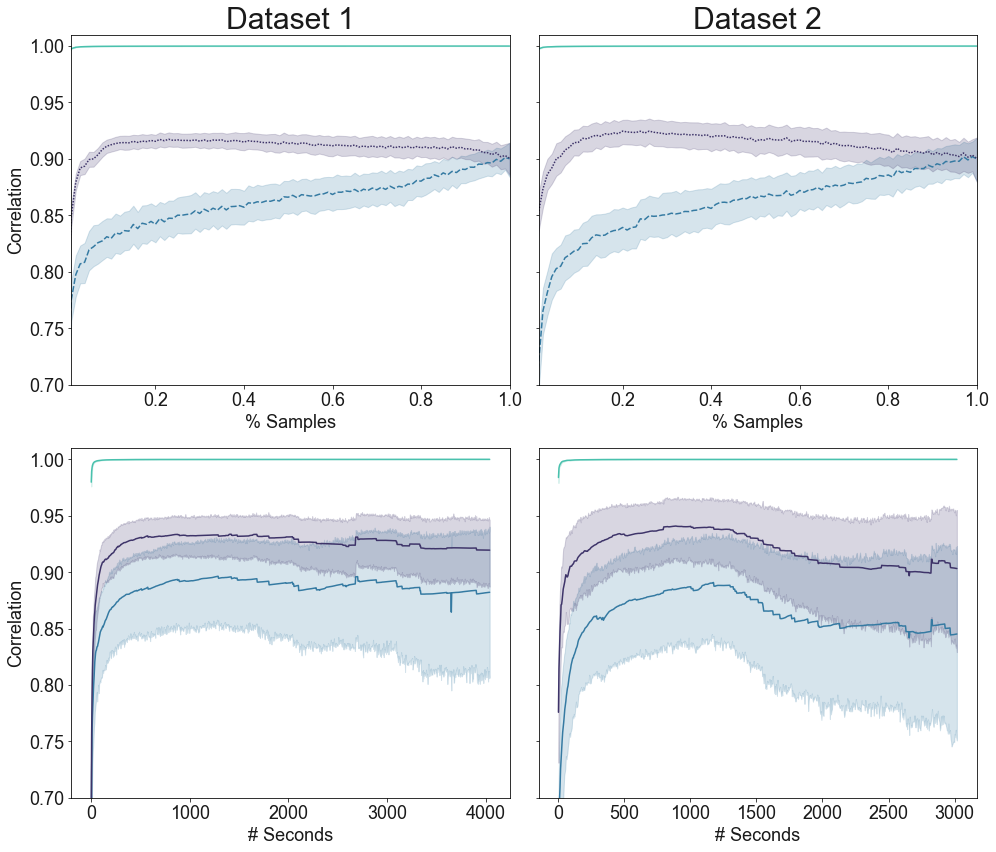

In [17]:
palette = sns.color_palette("mako_r", 3)
plt.rc('legend',fontsize=20)
f, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True)

sns.set(style="white", palette="muted", color_codes=True)

sns.lineplot(x="percent_idx", y="Correlation",
                  hue="Type", style="Type",data=pyFR_t_df_long, palette=palette, ax=axes[0, 0])
axes[0, 0].set(ylim=(.7, 1.01))
axes[0, 0].set(xlim=(.01, 1))
axes[0, 0].legend().set_visible(False)
axes[0, 0].axes.set_title("Dataset 1",fontsize=30)
axes[0, 0].set_xlabel("% Samples",fontsize=18)
axes[0, 0].set_ylabel("Correlation",fontsize=18)
axes[0, 0].tick_params(labelsize=18)


sns.lineplot(x="percent_idx", y="Correlation",
                  hue="Type", style="Type",data=RAM_t_df_long, palette=palette, ax=axes[0, 1])
axes[0, 1].set(ylim=(.7, 1.01))
axes[0, 1].set(xlim=(.01, 1))
axes[0, 1].axes.set_title("Dataset 2",fontsize=30)
axes[0, 1].set_xlabel("% Samples",fontsize=18)
axes[0, 1].set_ylabel("Correlation",fontsize=18)
axes[0, 1].tick_params(labelsize=18)
axes[0, 1].legend().set_visible(False)

sns.lineplot(x="second_idx", y="Correlation",
                  hue="Type",data=pyFR_half, palette=palette, ax=axes[1, 0])
axes[1, 0].set(ylim=(.7, 1.01))
axes[1, 0].set_xlabel("# Seconds",fontsize=18)
axes[1, 0].set_ylabel("Correlation",fontsize=18)
axes[1, 0].tick_params(labelsize=18)
axes[1, 0].legend().set_visible(False)

sns.lineplot(x="second_idx", y="Correlation",
                  hue="Type",data=RAM_half, palette=palette, ax=axes[1, 1])
axes[1, 1].set(ylim=(.7, 1.01))
axes[1, 1].set_xlabel("# Seconds",fontsize=18)
axes[1, 1].set_ylabel("Correlation",fontsize=18)
axes[1, 1].tick_params(labelsize=18)
axes[1, 1].legend().set_visible(False)

plt.tight_layout()
fname = os.path.join(fig_dir,'time_stability.pdf')

plt.savefig(fname)

## Individual lines RAM:

[(0.5, 1.01)]

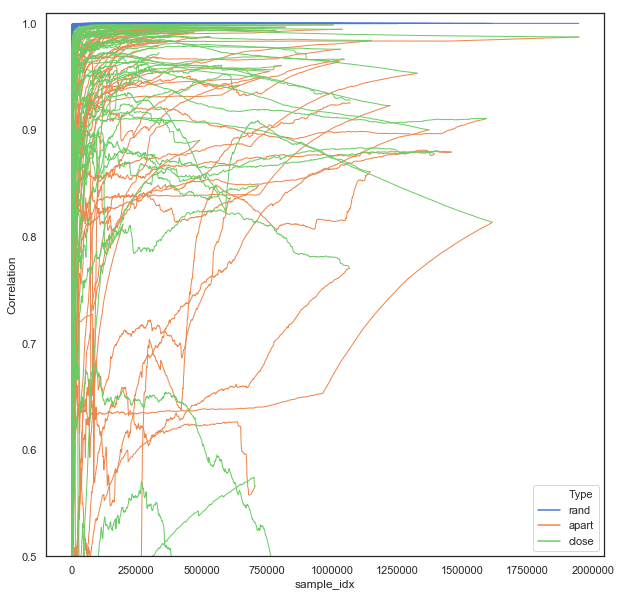

In [18]:
fig, ax = plt.subplots(figsize=[10,10])
ax = sns.lineplot(x="sample_idx", y="Correlation",
                  hue="Type",units="Subject", estimator=None, lw=1,data=RAM_t_df_long)
ax.set(ylim=(.5, 1.01))


## Individual line pyFR:

[(0.1, 1.01)]

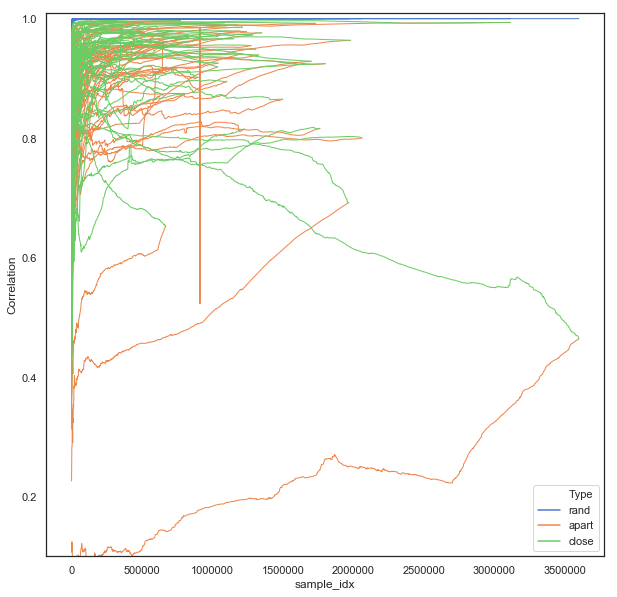

In [19]:
fig, ax = plt.subplots(figsize=[10,10])
ax = sns.lineplot(x="sample_idx", y="Correlation",
                  hue="Type",units="Subject", estimator=None, lw=1,data=pyFR_t_df_long)
ax.set(ylim=(.1, 1.01))
#ax.set(xlim=(.01, 1))

## Check stability across patient matrices:

In [20]:
RAM_p_df = np.load(os.path.join(ram_data_dir, 'ram_patient_stability.npz'))
pyFR_p_df = np.load(os.path.join(pyfr_data_dir, 'pyfr_patient_stability.npz'))

## Compile correlations

In [21]:
pyfr_corrs = pd.DataFrame()

for f in np.arange(pyFR_p_df['rand'].shape[0]):
    
    compile_temp = compile_corrs(pyFR_p_df['rand'], f)
    if pyfr_corrs.empty:
        pyfr_corrs = compile_temp
    else:
        pyfr_corrs = pyfr_corrs.append(compile_temp)
        
        
ram_corrs = pd.DataFrame()

for f in np.arange(RAM_p_df['rand'].shape[0]):
    
    compile_temp = compile_corrs(RAM_p_df['rand'], f)
    if ram_corrs.empty:
        ram_corrs = compile_temp
    else:
        ram_corrs = ram_corrs.append(compile_temp)
        

## Monte-Carlo resample for pyFR

In [22]:
pyfr_corrs_rand = pd.DataFrame()

for i in np.arange(100):
    
    rand_samp = np.zeros(pyFR_p_df['rand'].shape)
    for c in np.arange(pyFR_p_df['rand'].shape[1]):

        indices = np.random.choice(pyFR_p_df['rand'].shape[0], pyFR_p_df['rand'].shape[0], replace=True)
        rand_samp[:, c] = pyFR_p_df['rand'][indices][:, c]

    pyfr_corrs = pd.DataFrame()

    for f in np.arange(rand_samp.shape[0]):

        compile_temp = compile_corrs(rand_samp, f)
        if pyfr_corrs.empty:
            pyfr_corrs = compile_temp
        else:
            pyfr_corrs = pyfr_corrs.append(compile_temp)

    n_subs = pyfr_corrs.groupby('# Subjects').sem().reset_index()['# Subjects']+1
    sems = pyfr_corrs.groupby('# Subjects').std().reset_index()['Correlation']/n_subs

    sem_corr_temp = pd.DataFrame({'Correlation': sems, 'Iteration': i, '# Subjects': np.arange(sems.shape[0])+1})
    
    if pyfr_corrs_rand.empty:
        pyfr_corrs_rand = sem_corr_temp
    else:
        pyfr_corrs_rand = pyfr_corrs_rand.append(sem_corr_temp)
        

## Monte-Carlo resample for RAM

In [23]:
ram_corrs_rand = pd.DataFrame()

for i in np.arange(100):
    
    rand_samp = np.zeros(RAM_p_df['rand'].shape)
    for c in np.arange(RAM_p_df['rand'].shape[1]):

        indices = np.random.choice(RAM_p_df['rand'].shape[0], RAM_p_df['rand'].shape[0], replace=True)
        rand_samp[:, c] = RAM_p_df['rand'][indices][:, c]

    ram_corrs = pd.DataFrame()

    for f in np.arange(rand_samp.shape[0]):

        compile_temp = compile_corrs(rand_samp, f)
        if ram_corrs.empty:
            ram_corrs = compile_temp
        else:
            ram_corrs = ram_corrs.append(compile_temp)

    n_subs = ram_corrs.groupby('# Subjects').sem().reset_index()['# Subjects']+1
    sems = ram_corrs.groupby('# Subjects').std().reset_index()['Correlation']/n_subs

    sem_corr_temp = pd.DataFrame({'Correlation': sems, 'Iteration': i, '# Subjects': np.arange(sems.shape[0])+1})
    
    if ram_corrs_rand.empty:
        ram_corrs_rand = sem_corr_temp
    else:
        ram_corrs_rand = ram_corrs_rand.append(sem_corr_temp)
        

In [24]:
n_subs = pyfr_corrs.groupby('# Subjects').sem().reset_index()['# Subjects']+1
pyfr_sems = pyfr_corrs.groupby('# Subjects').std().reset_index()['Correlation']/n_subs
pyfr_sem_data = pd.DataFrame({'SEM': pyfr_sems, '# Subjects': np.arange(len(pyfr_sems))+1})

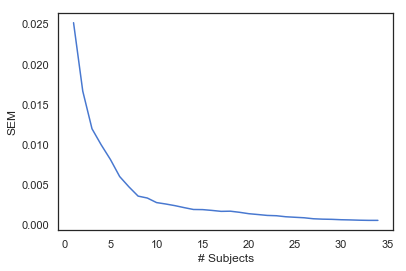

In [25]:
ax = sns.lineplot(x="# Subjects",y="SEM", data=pyfr_sem_data)
#ax.set(xlim=(0, 34))

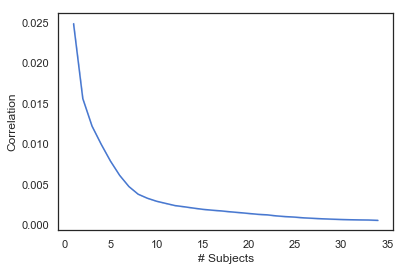

In [26]:

ax = sns.lineplot(x="# Subjects",y="Correlation", data=pyfr_corrs_rand)
# ax.set(xlim=(0, 2))
# ax.set(ylim=(.015, .02))


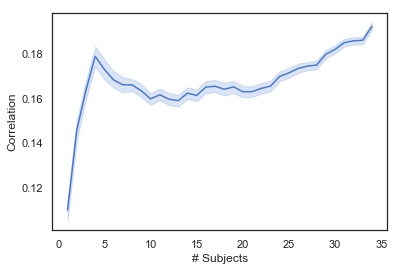

In [27]:
ax = sns.lineplot(x="# Subjects", y="Correlation", data=pyfr_corrs)

In [28]:
n_subs = ram_corrs.groupby('# Subjects').std().reset_index()['# Subjects']+1
ram_sems= ram_corrs.groupby('# Subjects').std().reset_index()['Correlation']/n_subs
ram_sem_data = pd.DataFrame({'SEM': ram_sems, '# Subjects': n_subs})

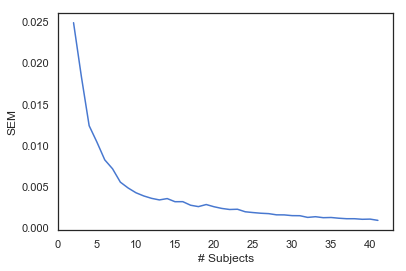

In [29]:

ax = sns.lineplot(x="# Subjects",y="SEM", data=ram_sem_data)

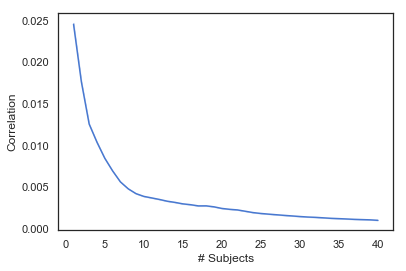

In [30]:

ax = sns.lineplot(x="# Subjects",y="Correlation", data=ram_corrs_rand)
# ax.set(xlim=(0, 2))
# ax.set(ylim=(.015, .02))


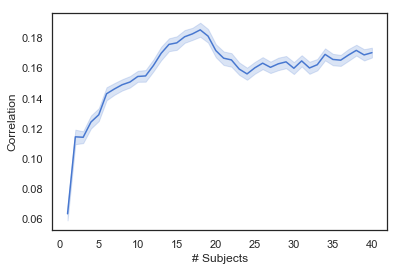

In [31]:
ax = sns.lineplot(x="# Subjects", y="Correlation", data=ram_corrs)

No handles with labels found to put in legend.


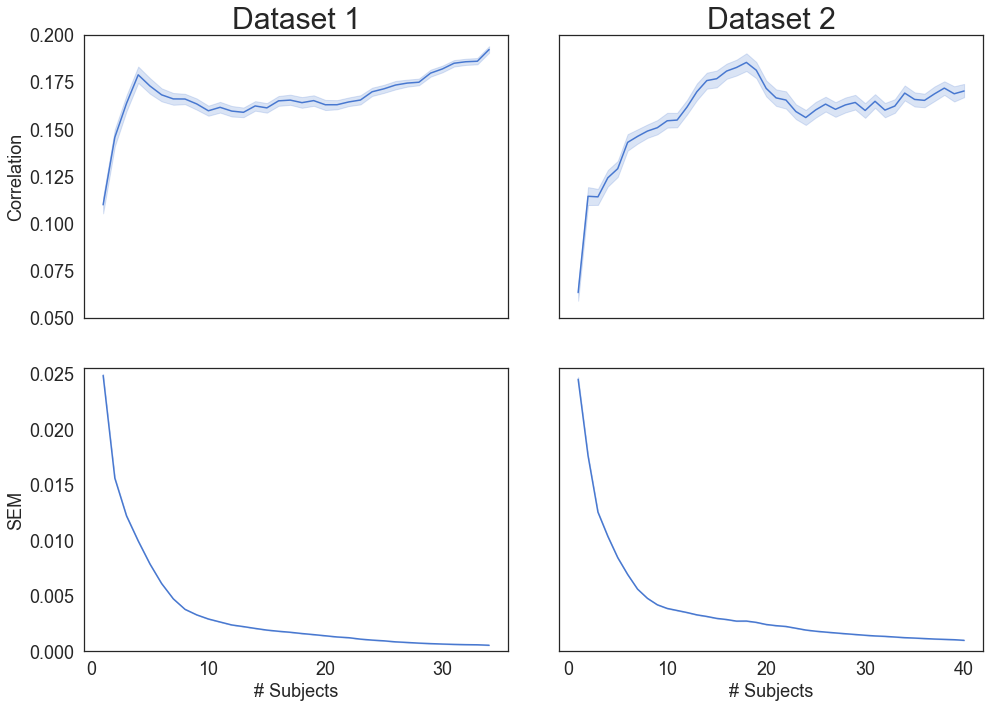

In [32]:
palette = sns.color_palette("mako_r", 1)
plt.rc('legend',fontsize=20)
f, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.set(style="white", palette="muted", color_codes=True)

sns.lineplot(x="# Subjects", y="Correlation", data=pyfr_corrs, palette=palette, ax=axes[0, 0])
axes[0, 0].set(ylim=(.05, .2))
# axes[0, 0].set(xlim=(.01, 1))
axes[0, 0].legend().set_visible(False)
axes[0, 0].axes.set_title("Dataset 1",fontsize=30)
axes[0, 0].set_xticklabels([])
axes[0, 0].set_xlabel(" ",fontsize=18)
axes[0, 0].set_ylabel("Correlation",fontsize=18)
axes[0, 0].tick_params(labelsize=18)

sns.lineplot(x="# Subjects", y="Correlation", data=ram_corrs, palette=palette, ax=axes[0, 1])
axes[0, 1].set(ylim=(.05, .2))
# axes[0, 1].set(xlim=(.01, 1))
axes[0, 1].axes.set_title("Dataset 2",fontsize=30)
axes[0, 1].set_xticklabels([])
axes[0, 1].set_yticklabels([])
axes[0, 1].set_xlabel(" ",fontsize=18)
axes[0, 1].set_ylabel(" ",fontsize=18)
axes[0, 1].tick_params(labelsize=18)

ax = sns.lineplot(x="# Subjects",y="Correlation", data=pyfr_corrs_rand, palette=palette, ax=axes[1, 0])
axes[1, 0].set(ylim=(0, .0255))
axes[1, 0].set_xlabel("# Subjects",fontsize=18)
axes[1, 0].set_ylabel("SEM",fontsize=18)
axes[1, 0].tick_params(labelsize=18)

ax = sns.lineplot(x="# Subjects",y="Correlation", data=ram_corrs_rand, palette=palette, ax=axes[1, 1])
axes[1, 1].set(ylim=(0, .0255))
axes[1, 1].set_yticklabels([])
# axes[1, 1].set_xticklabels([])
axes[1, 1].set_xlabel("# Subjects",fontsize=18)
axes[1, 1].set_ylabel(" ",fontsize=18)
axes[1, 1].tick_params(labelsize=18)

plt.tight_layout()
fname = os.path.join(fig_dir,'patient_stability.pdf')

plt.savefig(fname)